In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import tqdm
import pickle
import matplotlib
import numpy as np
import pandas as pd
import ase.io as aio
from ase import Atoms
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from toolz.curried import pipe, curry, compose

import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [4]:
import atom_stat as astat

In [5]:
import utilities as utils

In [6]:
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

In [7]:
runs = np.loadtxt("runs.txt").astype(int)
runs.shape

(77,)

In [8]:
def get_atom_subset(coords, 
                    c_min=np.array([-181.5]*3), 
                    r_stat=30, 
                    cell=np.array([362.95089012]*3)):
    
    x_bot = np.array([1.,1.,1.]) * r_stat
    x_top = cell - x_bot

    c_list = []
    for c in coords:
        if np.all((c - c_min) > x_bot) and np.all((c - c_min) < x_top):
            c_list.append(c[None])
            
    return np.concatenate(c_list, axis=0)

### When computing for damaged structures, atoms corresponding to the damaged region are considered.

In [9]:
%%time
ix=-1
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
             lambda f: utils.load_file(f))

# atoms = pipe("structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
#              lambda f: utils.load_file(f), 
#              get_atoms)

indexes = np.where(atoms.get_tags() != 1)[0]

print("No. of disturbed atoms: {}".format(len(indexes)))

coords_all = atoms.get_positions()
coords_sub = coords_all[indexes]

print(atoms.get_cell())

No. of disturbed atoms: 278104
Cell([362.950890120128, 362.950890120128, 362.950890120128])
CPU times: user 902 ms, sys: 201 ms, total: 1.1 s
Wall time: 368 ms


### Compute RDF

## $X(r) = \dfrac{n\left(r\right)}{\dfrac{4}{3}\pi(r_1^3 - r_0^3)n_0}$

In [27]:
r_stat = 10
len_pixel = 100
nbins = (r_stat + 2) * len_pixel + 1

In [10]:
%%time
coords_sub_in = get_atom_subset(coords_sub)

CPU times: user 1.89 s, sys: 9.55 ms, total: 1.9 s
Wall time: 1.91 s


In [29]:
%%time
rdf, pdf = astat.get_rdf_tree(coords_all, coords_sub_in, cutoff=r_stat, nbins=nbins)

CPU times: user 29.4 s, sys: 1.11 s, total: 30.5 s
Wall time: 30.6 s


### Visualize

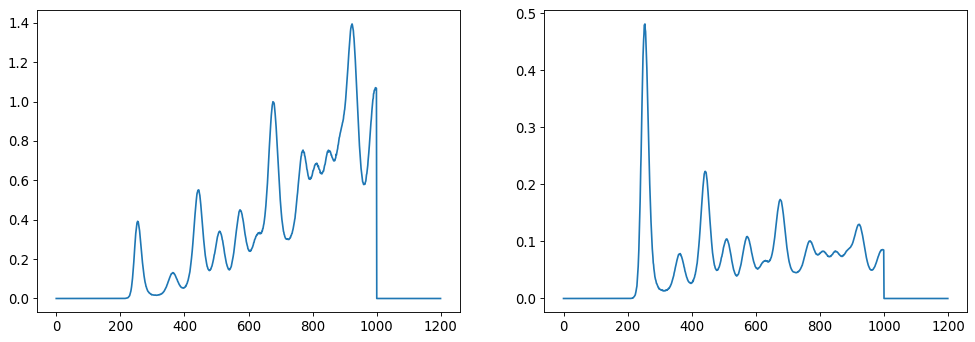

In [32]:
bins = np.linspace(0.0, r_stat+2, nbins)[1:]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))
ax[0].plot(bins, rdf)
ax[1].plot(bins, pdf[0:])
plt.show()

## Smoothening Protocol

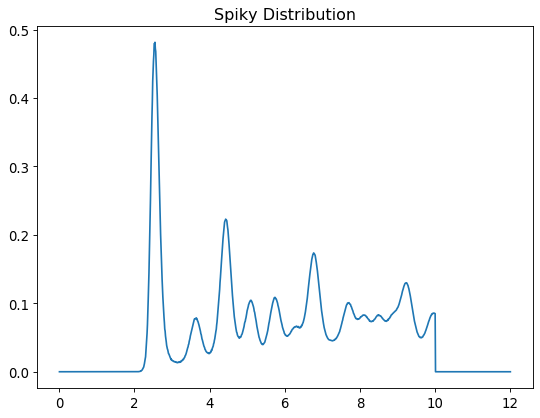

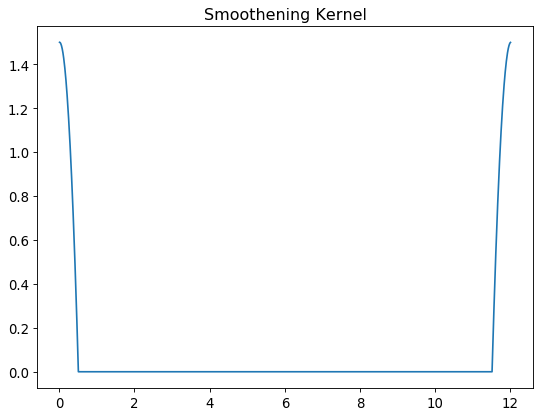

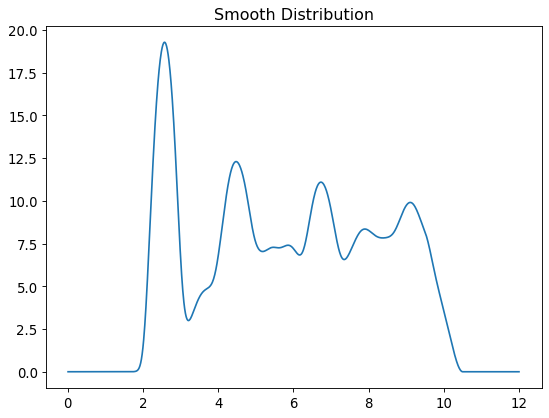

0.9849029999999996
68.61215823405847


In [33]:
bins = np.linspace(0.0, r_stat+2, nbins)[1:]

plt.plot(bins, pdf)
plt.title("Spiky Distribution")
plt.show()

kernel = astat.epanechnikov_kernel(width=0.5, x=bins)

plt.plot(bins, kernel)
plt.title("Smoothening Kernel")
plt.show()

new_pdf = astat.convolve_kernel(kernel, pdf)

plt.plot(bins, new_pdf)
plt.title("Smooth Distribution")
plt.show()

print(np.trapz(kernel, bins))
print(np.trapz(new_pdf, bins))

## Computation over all structures

In [11]:
folder_pdf = "data/pdfs"
if not os.path.exists(folder_pdf):
    os.mkdir(folder_pdf)

In [12]:
r_stat=15
len_pixel=50
nbins=(r_stat + 2) * len_pixel + 1
bins=np.linspace(0.0, r_stat + 2, nbins)[1:]
kernel=astat.epanechnikov_kernel(width=0.5, x=bins)

In [13]:
def generate_rdf(run, r_stat=r_stat, nbins=nbins):
    
    print(run)
    atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
                 lambda f: utils.load_file(f))
    
    indxs = np.where(atoms.get_tags() != 1)[0]

    coords_all = atoms.get_positions()
    coords_sub = coords_all[indxs]
    
    pdf = []
    if len(indxs) != 0:
        coords_sub_in = get_atom_subset(coords_sub, 
                                        c_min=np.array([-181.5]*3), 
                                        r_stat=30, 
                                        cell=np.array([362.95089012]*3))
        
        pdf = astat.get_rdf_tree(coords_all, coords_sub_in, cutoff=r_stat, nbins=nbins)[-1]
        utils.save_file(fname="{}/dump.arc.{}_pdf.pkl".format(folder_pdf, run), obj=pdf)

In [14]:
%%time
import multiprocessing as mp
n_proc = 10
with mp.Pool(n_proc) as p:
    p.map(generate_rdf, runs)

0
1000
2000
3000
4000
5000
6000
7000
9000
8000
500
10000
1500
2500
3500
4500
5500
7500
6500
11000
9500
8500
10500
12000
13000
14000
15000
16000
17000
18000
11500
19000
20000
12500
13500
14500
15500
16500
17500
21000
19500
18500
20500
22000
23000
24000
25000
26000
27000
28000
21500
29000
22500
30000
24500
23500
25500
26500
27500
28500
29500
31000
32000
30500
33000
34000
35000
36000
37000
38000
31500
32500
33500
34500
35500
36500
37500
CPU times: user 481 ms, sys: 358 ms, total: 839 ms
Wall time: 12min 13s
